In [1]:

import findspark
findspark.init()

In [5]:
%pip install matplotlib

  Using cached contourpy-1.2.0-cp39-cp39-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/158.1 kB ? eta -:--:--
     ------- ------------------------------- 30.7/158.1 kB 1.3 MB/s eta 0:00:01
     --------------------------- ---------- 112.6/158.1 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 158.1/158.1 kB 1.2 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp39-cp39-win_amd64.whl.metadata (6.5 kB)
  Using cached Pillow-10.1.0-cp39-cp39-win_amd64.whl.metadata (9.6 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_resources-6.1.1-py3-none-any.whl.metadata (4.1 kB)
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
    --------------------------------------- 0.2/7.6 MB 2.6 MB/s eta 0:00:03
   - -------------------------------------- 0.2/7

In [7]:
%pip install pandas

     ---------------------------------------- 0.0/341.8 kB ? eta -:--:--
     ---- -------------------------------- 41.0/341.8 kB 960.0 kB/s eta 0:00:01
     ------- ----------------------------- 71.7/341.8 kB 653.6 kB/s eta 0:00:01
     --------------- ---------------------- 143.4/341.8 kB 1.2 MB/s eta 0:00:01
     -------------------------- ----------- 235.5/341.8 kB 1.3 MB/s eta 0:00:01
     ---------------------------------- --- 307.2/341.8 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 341.8/341.8 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
    --------------------------------------- 0.3/10.8 MB 7.9 MB/s eta 0:00:02
   - -------------------------------------- 0.5/10.8 MB 4.9 MB/s eta 0:00:03
   - -------------------------------------- 0.5/10.8 MB 4.9 MB/s eta 0:00:03
   - -------------------------------------- 0.5/10.8 MB 2.6 MB/s eta 0:00:04
   -- ------------------------------------- 0.7/10.8 MB 2.7 MB/s eta 

In [2]:

import numpy as np
import pandas as pd
from functools import reduce
from pyspark.sql.functions import isnan, when, count, col
import matplotlib.pyplot as plt
from pyspark import SparkFiles
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator




### Spark session

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "15g").appName('TrafficAnalysis').getOrCreate()
print(spark)

In [4]:
data_path = "Dataset-Unicauca-Version2-87Atts.csv"
traffic_df = spark.read.options(header='True',inferSchema='True') \
                    .csv(path=data_path)
traffic_df.printSchema()

root
 |-- Flow.ID: string (nullable = true)
 |-- Source.IP: string (nullable = true)
 |-- Source.Port: integer (nullable = true)
 |-- Destination.IP: string (nullable = true)
 |-- Destination.Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow.Duration: integer (nullable = true)
 |-- Total.Fwd.Packets: integer (nullable = true)
 |-- Total.Backward.Packets: integer (nullable = true)
 |-- Total.Length.of.Fwd.Packets: integer (nullable = true)
 |-- Total.Length.of.Bwd.Packets: double (nullable = true)
 |-- Fwd.Packet.Length.Max: integer (nullable = true)
 |-- Fwd.Packet.Length.Min: integer (nullable = true)
 |-- Fwd.Packet.Length.Mean: double (nullable = true)
 |-- Fwd.Packet.Length.Std: double (nullable = true)
 |-- Bwd.Packet.Length.Max: integer (nullable = true)
 |-- Bwd.Packet.Length.Min: integer (nullable = true)
 |-- Bwd.Packet.Length.Mean: double (nullable = true)
 |-- Bwd.Packet.Length.Std: double (nullable = 

### Preprocessing

In [5]:

current_columns = traffic_df.columns


final_df = traffic_df
for c in current_columns:
    new_col_name = c.replace(" ", "_").replace(".", "_").upper().strip()
    final_df = final_df.withColumnRenamed(c, new_col_name)


final_df.printSchema()

root
 |-- FLOW_ID: string (nullable = true)
 |-- SOURCE_IP: string (nullable = true)
 |-- SOURCE_PORT: integer (nullable = true)
 |-- DESTINATION_IP: string (nullable = true)
 |-- DESTINATION_PORT: integer (nullable = true)
 |-- PROTOCOL: integer (nullable = true)
 |-- TIMESTAMP: string (nullable = true)
 |-- FLOW_DURATION: integer (nullable = true)
 |-- TOTAL_FWD_PACKETS: integer (nullable = true)
 |-- TOTAL_BACKWARD_PACKETS: integer (nullable = true)
 |-- TOTAL_LENGTH_OF_FWD_PACKETS: integer (nullable = true)
 |-- TOTAL_LENGTH_OF_BWD_PACKETS: double (nullable = true)
 |-- FWD_PACKET_LENGTH_MAX: integer (nullable = true)
 |-- FWD_PACKET_LENGTH_MIN: integer (nullable = true)
 |-- FWD_PACKET_LENGTH_MEAN: double (nullable = true)
 |-- FWD_PACKET_LENGTH_STD: double (nullable = true)
 |-- BWD_PACKET_LENGTH_MAX: integer (nullable = true)
 |-- BWD_PACKET_LENGTH_MIN: integer (nullable = true)
 |-- BWD_PACKET_LENGTH_MEAN: double (nullable = true)
 |-- BWD_PACKET_LENGTH_STD: double (nullable = 

In [6]:
final_df.columns

['FLOW_ID',
 'SOURCE_IP',
 'SOURCE_PORT',
 'DESTINATION_IP',
 'DESTINATION_PORT',
 'PROTOCOL',
 'TIMESTAMP',
 'FLOW_DURATION',
 'TOTAL_FWD_PACKETS',
 'TOTAL_BACKWARD_PACKETS',
 'TOTAL_LENGTH_OF_FWD_PACKETS',
 'TOTAL_LENGTH_OF_BWD_PACKETS',
 'FWD_PACKET_LENGTH_MAX',
 'FWD_PACKET_LENGTH_MIN',
 'FWD_PACKET_LENGTH_MEAN',
 'FWD_PACKET_LENGTH_STD',
 'BWD_PACKET_LENGTH_MAX',
 'BWD_PACKET_LENGTH_MIN',
 'BWD_PACKET_LENGTH_MEAN',
 'BWD_PACKET_LENGTH_STD',
 'FLOW_BYTES_S',
 'FLOW_PACKETS_S',
 'FLOW_IAT_MEAN',
 'FLOW_IAT_STD',
 'FLOW_IAT_MAX',
 'FLOW_IAT_MIN',
 'FWD_IAT_TOTAL',
 'FWD_IAT_MEAN',
 'FWD_IAT_STD',
 'FWD_IAT_MAX',
 'FWD_IAT_MIN',
 'BWD_IAT_TOTAL',
 'BWD_IAT_MEAN',
 'BWD_IAT_STD',
 'BWD_IAT_MAX',
 'BWD_IAT_MIN',
 'FWD_PSH_FLAGS',
 'BWD_PSH_FLAGS',
 'FWD_URG_FLAGS',
 'BWD_URG_FLAGS',
 'FWD_HEADER_LENGTH',
 'BWD_HEADER_LENGTH',
 'FWD_PACKETS_S',
 'BWD_PACKETS_S',
 'MIN_PACKET_LENGTH',
 'MAX_PACKET_LENGTH',
 'PACKET_LENGTH_MEAN',
 'PACKET_LENGTH_STD',
 'PACKET_LENGTH_VARIANCE',
 'FIN_FLAG_

In [7]:

final_df.count()

3577296

In [8]:
# Feature selection

sub_df = final_df.select('FLOW_ID',
 'SOURCE_IP',
 'SOURCE_PORT',
 'DESTINATION_IP',
 'DESTINATION_PORT',
 'PROTOCOL',
 'TIMESTAMP',
 'FLOW_DURATION',
 'TOTAL_FWD_PACKETS',
 'TOTAL_BACKWARD_PACKETS',
 'TOTAL_LENGTH_OF_FWD_PACKETS',
 'TOTAL_LENGTH_OF_BWD_PACKETS',
 'FLOW_BYTES_S',
 'FLOW_PACKETS_S',
 'AVERAGE_PACKET_SIZE',
 'LABEL',
 'PROTOCOLNAME')
sub_df.show(10)

+--------------------+-------------+-----------+--------------+----------------+--------+------------------+-------------+-----------------+----------------------+---------------------------+---------------------------+----------------+----------------+-------------------+------+------------+
|             FLOW_ID|    SOURCE_IP|SOURCE_PORT|DESTINATION_IP|DESTINATION_PORT|PROTOCOL|         TIMESTAMP|FLOW_DURATION|TOTAL_FWD_PACKETS|TOTAL_BACKWARD_PACKETS|TOTAL_LENGTH_OF_FWD_PACKETS|TOTAL_LENGTH_OF_BWD_PACKETS|    FLOW_BYTES_S|  FLOW_PACKETS_S|AVERAGE_PACKET_SIZE| LABEL|PROTOCOLNAME|
+--------------------+-------------+-----------+--------------+----------------+--------+------------------+-------------+-----------------+----------------------+---------------------------+---------------------------+----------------+----------------+-------------------+------+------------+
|172.19.1.46-10.20...|  172.19.1.46|      52422|    10.200.7.7|            3128|       6|26/04/201711:11:17|        45

In [9]:

sub_df.groupBy("PROTOCOLNAME").count().show()

+-------------+------+
| PROTOCOLNAME| count|
+-------------+------+
|      TWITTER| 18259|
|          DNS|  1695|
|          MSN| 14478|
| HTTP_CONNECT|317526|
|       TWITCH|    24|
|          SSH|   102|
|HTTP_DOWNLOAD|   516|
|         MQTT|   302|
|    INSTAGRAM|  2415|
|   OPENSIGNAL|     9|
|     WHATSAPP|  4593|
|    MICROSOFT| 54710|
| MS_ONE_DRIVE|  1748|
| APPLE_ITUNES|  1287|
|      SPOTIFY|  1269|
|   OFFICE_365|  5941|
|CONTENT_FLASH|  8589|
|        GMAIL| 40260|
|        APPLE|  7615|
|        SKYPE| 30657|
+-------------+------+
only showing top 20 rows



In [10]:

sub_df.select('FLOW_DURATION').describe().show()

+-------+--------------------+
|summary|       FLOW_DURATION|
+-------+--------------------+
|  count|             3577296|
|   mean|2.5442465812041834E7|
| stddev|  4.01443005446156E7|
|    min|                   1|
|    max|           120000000|
+-------+--------------------+



In [11]:

sub_df.select([count(when(isnan(c), c)).alias(c) for c in sub_df.columns]).show()

+-------+---------+-----------+--------------+----------------+--------+---------+-------------+-----------------+----------------------+---------------------------+---------------------------+------------+--------------+-------------------+-----+------------+
|FLOW_ID|SOURCE_IP|SOURCE_PORT|DESTINATION_IP|DESTINATION_PORT|PROTOCOL|TIMESTAMP|FLOW_DURATION|TOTAL_FWD_PACKETS|TOTAL_BACKWARD_PACKETS|TOTAL_LENGTH_OF_FWD_PACKETS|TOTAL_LENGTH_OF_BWD_PACKETS|FLOW_BYTES_S|FLOW_PACKETS_S|AVERAGE_PACKET_SIZE|LABEL|PROTOCOLNAME|
+-------+---------+-----------+--------------+----------------+--------+---------+-------------+-----------------+----------------------+---------------------------+---------------------------+------------+--------------+-------------------+-----+------------+
|      0|        0|          0|             0|               0|       0|        0|            0|                0|                     0|                          0|                          0|           0|           

In [12]:

sub_df.select('PROTOCOLNAME').distinct().collect()

[Row(PROTOCOLNAME='TWITTER'),
 Row(PROTOCOLNAME='DNS'),
 Row(PROTOCOLNAME='MSN'),
 Row(PROTOCOLNAME='HTTP_CONNECT'),
 Row(PROTOCOLNAME='TWITCH'),
 Row(PROTOCOLNAME='SSH'),
 Row(PROTOCOLNAME='HTTP_DOWNLOAD'),
 Row(PROTOCOLNAME='MQTT'),
 Row(PROTOCOLNAME='INSTAGRAM'),
 Row(PROTOCOLNAME='OPENSIGNAL'),
 Row(PROTOCOLNAME='WHATSAPP'),
 Row(PROTOCOLNAME='MICROSOFT'),
 Row(PROTOCOLNAME='MS_ONE_DRIVE'),
 Row(PROTOCOLNAME='APPLE_ITUNES'),
 Row(PROTOCOLNAME='SPOTIFY'),
 Row(PROTOCOLNAME='OFFICE_365'),
 Row(PROTOCOLNAME='CONTENT_FLASH'),
 Row(PROTOCOLNAME='GMAIL'),
 Row(PROTOCOLNAME='APPLE'),
 Row(PROTOCOLNAME='SKYPE'),
 Row(PROTOCOLNAME='TOR'),
 Row(PROTOCOLNAME='YAHOO'),
 Row(PROTOCOLNAME='FACEBOOK'),
 Row(PROTOCOLNAME='TEAMVIEWER'),
 Row(PROTOCOLNAME='MAIL_IMAPS'),
 Row(PROTOCOLNAME='WIKIPEDIA'),
 Row(PROTOCOLNAME='NETFLIX'),
 Row(PROTOCOLNAME='SSL_NO_CERT'),
 Row(PROTOCOLNAME='APPLE_ICLOUD'),
 Row(PROTOCOLNAME='NTP'),
 Row(PROTOCOLNAME='UBUNTUONE'),
 Row(PROTOCOLNAME='WINDOWS_UPDATE'),
 Row(PR

In [13]:
socialMedias = ['TWITTER','INSTAGRAM','FACEBOOK']

records = sub_df.filter(sub_df.PROTOCOLNAME.isin(socialMedias))

records.show(5)

+--------------------+-------------+-----------+--------------+----------------+--------+------------------+-------------+-----------------+----------------------+---------------------------+---------------------------+----------------+----------------+-------------------+------+------------+
|             FLOW_ID|    SOURCE_IP|SOURCE_PORT|DESTINATION_IP|DESTINATION_PORT|PROTOCOL|         TIMESTAMP|FLOW_DURATION|TOTAL_FWD_PACKETS|TOTAL_BACKWARD_PACKETS|TOTAL_LENGTH_OF_FWD_PACKETS|TOTAL_LENGTH_OF_BWD_PACKETS|    FLOW_BYTES_S|  FLOW_PACKETS_S|AVERAGE_PACKET_SIZE| LABEL|PROTOCOLNAME|
+--------------------+-------------+-----------+--------------+----------------+--------+------------------+-------------+-----------------+----------------------+---------------------------+---------------------------+----------------+----------------+-------------------+------+------------+
|157.240.0.22-10.2...| 10.200.7.217|      53809|  157.240.0.22|             443|       6|26/04/201711:11:18|          

### Data Visualizations & Analysis

<Axes: xlabel='PROTOCOLNAME', ylabel='count'>

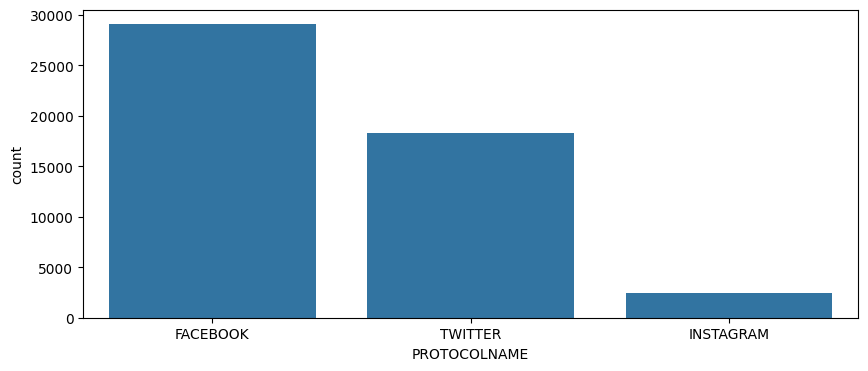

In [14]:
# %pip install seaborn

records_df = records.toPandas()
records_df['TIMESTAMP'] = pd.to_datetime(records_df['TIMESTAMP'],format= '%d/%m/%Y%H:%M:%S' )

# bar plot
import seaborn as sns
plt.figure(figsize=(10,4))
sns.countplot(x = 'PROTOCOLNAME', data = records_df)

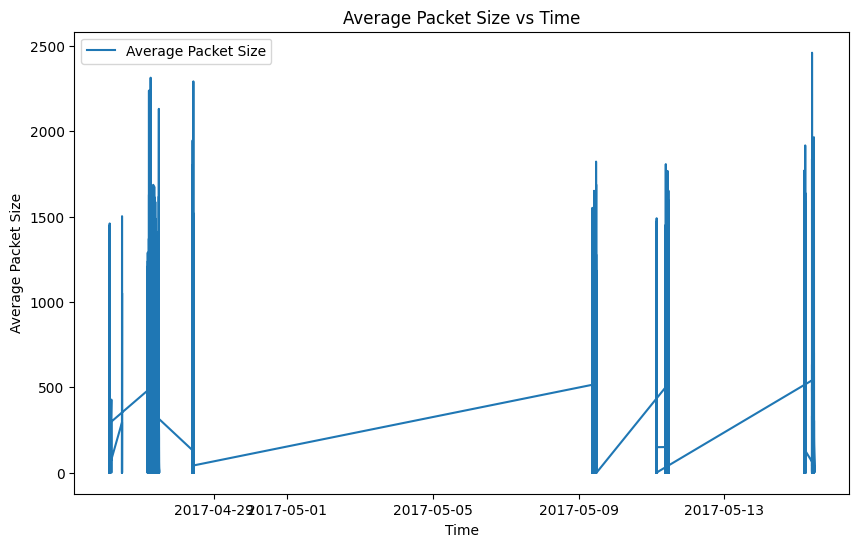

In [15]:
import matplotlib.pyplot as plt




filtered_df = records_df[records_df['PROTOCOLNAME'] == 'FACEBOOK']


plt.figure(figsize=(10, 6))
plt.plot(filtered_df['TIMESTAMP'], filtered_df['AVERAGE_PACKET_SIZE'], label='Average Packet Size')


plt.title('Average Packet Size vs Time')
plt.xlabel('Time')
plt.ylabel('Average Packet Size')
plt.legend()



plt.show()


### Training

In [16]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression,\
                    RandomForestClassifier,  DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



In [17]:
drop_list =['FLOW_ID',
 'SOURCE_IP',
 'SOURCE_PORT',
 'DESTINATION_IP',
 'DESTINATION_PORT',
 'PROTOCOL',
 'TIMESTAMP',
 'LABEL'
 ]
records__df = records.select([column for column in records.columns if column not in drop_list])

In [18]:
records__df.columns

['FLOW_DURATION',
 'TOTAL_FWD_PACKETS',
 'TOTAL_BACKWARD_PACKETS',
 'TOTAL_LENGTH_OF_FWD_PACKETS',
 'TOTAL_LENGTH_OF_BWD_PACKETS',
 'FLOW_BYTES_S',
 'FLOW_PACKETS_S',
 'AVERAGE_PACKET_SIZE',
 'PROTOCOLNAME']

In [19]:

distinct_values = records__df.select('PROTOCOLNAME').distinct()

distinct_values.show()

+------------+
|PROTOCOLNAME|
+------------+
|     TWITTER|
|   INSTAGRAM|
|    FACEBOOK|
+------------+



In [20]:

stringIndexer = StringIndexer(inputCol="PROTOCOLNAME", outputCol="PROTOCOL_INDEX")


records__df = stringIndexer.fit(records__df).transform(records__df)


records__df = records__df.drop("PROTOCOLNAME")


records__df = records__df.withColumnRenamed("PROTOCOL_INDEX", "PROTOCOLNAME")

records__df.show(5)


+-------------+-----------------+----------------------+---------------------------+---------------------------+----------------+----------------+-------------------+------------+
|FLOW_DURATION|TOTAL_FWD_PACKETS|TOTAL_BACKWARD_PACKETS|TOTAL_LENGTH_OF_FWD_PACKETS|TOTAL_LENGTH_OF_BWD_PACKETS|    FLOW_BYTES_S|  FLOW_PACKETS_S|AVERAGE_PACKET_SIZE|PROTOCOLNAME|
+-------------+-----------------+----------------------+---------------------------+---------------------------+----------------+----------------+-------------------+------------+
|            1|                2|                     0|                          0|                        0.0|             0.0|       2000000.0|                0.0|         0.0|
|        14276|                5|                    17|                        233|                     8900.0|  639745.0266181|1541.04791258055|   415.136363636364|         0.0|
|        15072|                5|                    16|                        233|                

In [21]:

distinct_values = records__df.select('PROTOCOLNAME').distinct()

distinct_values.show()

+------------+
|PROTOCOLNAME|
+------------+
|         0.0|
|         1.0|
|         2.0|
+------------+



In [22]:
vec_asmbl = VectorAssembler(inputCols=['FLOW_DURATION',
 'TOTAL_FWD_PACKETS',
 'TOTAL_BACKWARD_PACKETS',
 'TOTAL_LENGTH_OF_FWD_PACKETS',
 'TOTAL_LENGTH_OF_BWD_PACKETS',
 'FLOW_BYTES_S',
 'FLOW_PACKETS_S',
 'AVERAGE_PACKET_SIZE'],
                           outputCol='features')

records__df = vec_asmbl.transform(records__df).select('features','PROTOCOLNAME')
records__df.show(4, truncate=False)

+----------------------------------------------------------------------------------+------------+
|features                                                                          |PROTOCOLNAME|
+----------------------------------------------------------------------------------+------------+
|(8,[0,1,6],[1.0,2.0,2000000.0])                                                   |0.0         |
|[14276.0,5.0,17.0,233.0,8900.0,639745.0266181,1541.04791258055,415.136363636364]  |0.0         |
|[15072.0,5.0,16.0,233.0,8900.0,605958.067940552,1393.31210191083,434.904761904762]|0.0         |
|[3703.0,5.0,16.0,233.0,8900.0,2466378.61193627,5671.0775047259,434.904761904762]  |0.0         |
+----------------------------------------------------------------------------------+------------+
only showing top 4 rows



In [23]:

train_df, valid_df = records__df.randomSplit([0.8, 0.2])

In [25]:


def evaluate_model(model,pred):
    evaluator = MulticlassClassificationEvaluator(labelCol='PROTOCOLNAME',
                                          metricName='accuracy')
    accuracy = evaluator.evaluate(pred)
    print(f"Accuracy of {model} is {accuracy}")

    #precison
    evaluator = MulticlassClassificationEvaluator(labelCol='PROTOCOLNAME',
                                              metricName='weightedPrecision')
    precision = evaluator.evaluate(pred)
    print(f"Precision of {model} is {precision}")
    
    #recall

    evaluator = MulticlassClassificationEvaluator(labelCol='PROTOCOLNAME',
                                                metricName='weightedRecall')
    
    recall = evaluator.evaluate(pred)
    print(f"Recall of {model} is {recall}")

    #f1 score

    evaluator = MulticlassClassificationEvaluator(labelCol='PROTOCOLNAME',
                                                metricName='f1')
    f1 = evaluator.evaluate(pred)
    print(f"F1 score of {model} is {f1}")

    return accuracy, precision, recall, f1

In [26]:
#Ridge Regression model
ridge = LogisticRegression(labelCol='PROTOCOLNAME',
                        maxIter=100,
                        elasticNetParam=0,
                        regParam=0.03,family='multinomial')

ridge_model = ridge.fit(train_df)
ridge_pred = ridge_model.transform(valid_df)
evaluate_model(ridge_model,ridge_pred)


Accuracy of LogisticRegressionModel: uid=LogisticRegression_ecfeb8e8cda6, numClasses=3, numFeatures=8 is 0.6455238859895625
Precision of LogisticRegressionModel: uid=LogisticRegression_ecfeb8e8cda6, numClasses=3, numFeatures=8 is 0.638162741951317
Recall of LogisticRegressionModel: uid=LogisticRegression_ecfeb8e8cda6, numClasses=3, numFeatures=8 is 0.6455238859895625
F1 score of LogisticRegressionModel: uid=LogisticRegression_ecfeb8e8cda6, numClasses=3, numFeatures=8 is 0.5736117062335389


(0.6455238859895625, 0.638162741951317, 0.6455238859895625, 0.5736117062335389)

In [27]:
#Lasso Regression model
lasso = LogisticRegression(labelCol='PROTOCOLNAME',
                           maxIter=100,
                           elasticNetParam=1,
                           regParam=0.0003,family='multinomial')

lasso_model = lasso.fit(train_df)
lasso_pred = lasso_model.transform(valid_df)
evaluate_model(lasso_model,lasso_pred)

Accuracy of LogisticRegressionModel: uid=LogisticRegression_180f32a6a823, numClasses=3, numFeatures=8 is 0.6693095142513047
Precision of LogisticRegressionModel: uid=LogisticRegression_180f32a6a823, numClasses=3, numFeatures=8 is 0.6693038281987518
Recall of LogisticRegressionModel: uid=LogisticRegression_180f32a6a823, numClasses=3, numFeatures=8 is 0.6693095142513047
F1 score of LogisticRegressionModel: uid=LogisticRegression_180f32a6a823, numClasses=3, numFeatures=8 is 0.6084776289716662


(0.6693095142513047,
 0.6693038281987518,
 0.6693095142513047,
 0.6084776289716662)

In [28]:
#Random Forest Classifier Model
rf = RandomForestClassifier(labelCol='PROTOCOLNAME',
                           numTrees=100, maxDepth=3)

rf_model = rf.fit(train_df)
rf_pred = rf_model.transform(valid_df)
evaluate_model(rf_model,rf_pred)

Accuracy of RandomForestClassificationModel: uid=RandomForestClassifier_6c5d9f8bc93d, numTrees=100, numClasses=3, numFeatures=8 is 0.758129265355279
Precision of RandomForestClassificationModel: uid=RandomForestClassifier_6c5d9f8bc93d, numTrees=100, numClasses=3, numFeatures=8 is 0.7309262715881449
Recall of RandomForestClassificationModel: uid=RandomForestClassifier_6c5d9f8bc93d, numTrees=100, numClasses=3, numFeatures=8 is 0.7581292653552789
F1 score of RandomForestClassificationModel: uid=RandomForestClassifier_6c5d9f8bc93d, numTrees=100, numClasses=3, numFeatures=8 is 0.7315268456648572


(0.758129265355279, 0.7309262715881449, 0.7581292653552789, 0.7315268456648572)

In [29]:
dt= DecisionTreeClassifier(labelCol='PROTOCOLNAME'
                           )
dt_model = dt.fit(train_df)
dt_pred = dt_model.transform(valid_df)
evaluate_model(dt_model,dt_pred)

Accuracy of DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e14e20f68c8a, depth=5, numNodes=53, numClasses=3, numFeatures=8 is 0.8047972701726215
Precision of DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e14e20f68c8a, depth=5, numNodes=53, numClasses=3, numFeatures=8 is 0.809275365961424
Recall of DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e14e20f68c8a, depth=5, numNodes=53, numClasses=3, numFeatures=8 is 0.8047972701726215
F1 score of DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e14e20f68c8a, depth=5, numNodes=53, numClasses=3, numFeatures=8 is 0.789776966021722


(0.8047972701726215, 0.809275365961424, 0.8047972701726215, 0.789776966021722)

### Pipeline

In [30]:
#Creating pipeline
pipeline_dt = Pipeline(stages=[dt])

#Creating evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='PROTOCOLNAME', metricName='accuracy')

#Creating Grid
paramGrid = ParamGridBuilder().\
            addGrid(dt.maxDepth, [3, 4, 5]).\
            addGrid(dt.minInfoGain, [0.001, 0.01, 0.1]).\
            build()

#Initializing crossvalidator
selected_model = CrossValidator(estimator=pipeline_dt,
                                estimatorParamMaps=paramGrid,
                                evaluator=evaluator,
                                numFolds=5)

model_final = selected_model.fit(train_df)
pred_train = model_final.transform(valid_df)
evaluate_model(model_final, pred_train)


Accuracy of CrossValidatorModel_977f69ce2d3d is 0.804696908871939
Precision of CrossValidatorModel_977f69ce2d3d is 0.809172032043196
Recall of CrossValidatorModel_977f69ce2d3d is 0.804696908871939
F1 score of CrossValidatorModel_977f69ce2d3d is 0.789675943856393


(0.804696908871939, 0.809172032043196, 0.804696908871939, 0.789675943856393)

In [ ]:

model_final.write().save('network_traffic_analysis.model')

In [31]:

from pyspark.ml.tuning import CrossValidatorModel

loaded_model = CrossValidatorModel.load('network_traffic_analysis.model')